# U.S. EQUITY SECTORS SENSITIVITY TO INFLATION EXPECTATION CHANGES

In [2]:
end_date = "2024-05-28"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

import pandas_datareader.data as pdr
import yfinance as yf

import requests
from bs4 import BeautifulSoup  # Assuming you have BeautifulSoup installed

pd.options.display.float_format = '{:20,.4f}'.format

import warnings

This notebook explores the relationship between U.S. equity sectors and inflation. In the context of regression analysis, I propose the 5-year breakeven inflation as a more suitable proxy than the Consumer Price Index (CPI). The CPI, a backward-looking survey measure published monthly with a delay, does not provide real-time data. This misalignment with equity markets, which are forward-looking and have real-time price data, is a key issue. The 5-year breakeven inflation, calculated by subtracting the yield on inflation-protected Treasury bonds (TIPS) from the yield on treasury bonds, offers a solution. This measure of inflation expectations is forward-looking and can be directly computed from daily market movements, making it particularly useful for comparison with daily market returns. I will use the real (inflation-adjusted) yield on a 5-year TIPS for the real interest rate.

For our linear regression, we will use a three-factor model:

- 5-Year Breakeven Inflation Expectations Change (T5YEI_DIFF)
- 5-Year Real Interest Rates Change (DFII5_DIFF)
- U.S. Stock Market Price Change (MKT)


#### IMPORT & CLEAN DATA

We will use the Federal Reserve Economic Data (https://fred.stlouisfed.org/), or FRED, for our breakeven inflation and real interest rate data.

In [3]:
start_date = "1999-01-01"

T5YIE_Data = pdr.get_data_fred("T5YIE", start = start_date, end = end_date) # 5-Year Breakeven Inflation Rate (T5YIE)
DFII5_Data = pdr.get_data_fred("DFII5", start = start_date, end = end_date) # Market Yield on U.S. Treasury Securities at 5-Year Constant Maturity, Quoted on an Investment Basis, Inflation-Indexed

For sector ETFs, we use the iShares line-up below:

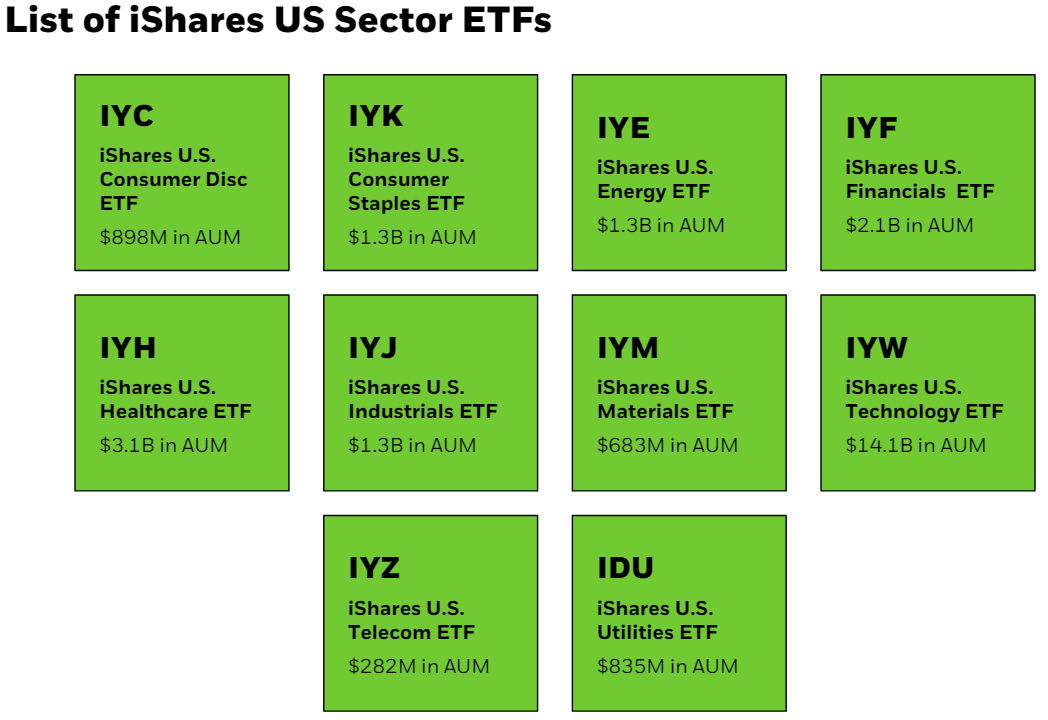

However, this sector ETF list lacks REITS (Real Estate Investment Trusts). We should include those in our analysis using the corresponding iShares ETF (Ticker: IYR). Further, we will use Vanguard Total Market ETF (Ticker: VTI) for the U.S. Total Marker. Below, we download the closing prices of the respective ETFs:  

In [4]:
warnings.filterwarnings('ignore')

IYZ = yf.Ticker('IYZ') # Communication
IYC = yf.Ticker('IYC') # Consumer Discretionary
IYK = yf.Ticker('IYK') # Consumer Staples
IYE = yf.Ticker('IYE') # Energy
IYF = yf.Ticker('IYF') # Financials
IYH = yf.Ticker('IYH') # Healthcare
IYJ = yf.Ticker('IYJ') # Industrials
IYW = yf.Ticker('IYW') # Technology
IYR = yf.Ticker('IYR') # REITS (Real Estate)
IDU = yf.Ticker('IDU') # Utilities
IYM = yf.Ticker('IYM') # Materials

VTI = yf.Ticker('VTI') # U.S. Total Stock Market

IYZ_CLOSE = IYZ.history(start=start_date, period="1d").Close
IYC_CLOSE = IYC.history(start=start_date, period="1d").Close
IYK_CLOSE = IYK.history(start=start_date, period="1d").Close
IYE_CLOSE = IYE.history(start=start_date, period="1d").Close
IYF_CLOSE = IYF.history(start=start_date, period="1d").Close
IYH_CLOSE = IYH.history(start=start_date, period="1d").Close
IYJ_CLOSE = IYJ.history(start=start_date, period="1d").Close
IYW_CLOSE = IYW.history(start=start_date, period="1d").Close
IYR_CLOSE = IYR.history(start=start_date, period="1d").Close
IDU_CLOSE = IDU.history(start=start_date, period="1d").Close
IYM_CLOSE = IYM.history(start=start_date, period="1d").Close

VTI_CLOSE = VTI.history(start=start_date, period="1d").Close


Let's combine all the data into one DataFrame and create a new DataFrame containing the daily percentage change in closing prices (daily price return).

In [5]:
ETF_CLOSE = pd.concat([IYZ_CLOSE, IYC_CLOSE, IYK_CLOSE, IYE_CLOSE, IYF_CLOSE, IYH_CLOSE, IYJ_CLOSE, IYW_CLOSE, IYR_CLOSE, IDU_CLOSE, IYM_CLOSE, VTI_CLOSE], axis=1).ffill()
ETF_CLOSE.columns = ["IYZ", "IYC", "IYK", "IYE", "IYF", "IYH", "IYJ", "IYW", "IYR", "IDU", "IYM", "VTI"]
ETF_CLOSE.index = ETF_CLOSE.index.tz_convert(None)

ETF_RETS_D = ETF_CLOSE.pct_change().dropna()
ETF_RETS_D

,IYZ,IYC,IYK,IYE,IYF,IYH,IYJ,IYW,IYR,IDU,IYM,VTI
Date,,,,,,,,,,,,
2001-06-18 04:00:00,-0.0231,-0.0002,-0.0096,-0.0081,-0.0013,0.0008,0.0009,-0.0200,0.0055,-0.0023,-0.0018,-0.0064
2001-06-19 04:00:00,-0.0109,0.0035,-0.0025,-0.0013,0.0123,0.0087,-0.0146,0.0000,-0.0010,-0.0072,0.0069,0.0028
2001-06-20 04:00:00,0.0180,0.0147,0.0022,-0.0184,0.0132,0.0157,0.0025,0.0036,0.0094,0.0085,0.0066,0.0105
2001-06-21 04:00:00,0.0117,0.0238,0.0162,-0.0191,0.0259,0.0031,0.0095,0.0151,0.0038,-0.0353,-0.0091,0.0080
2001-06-22 04:00:00,-0.0028,-0.0195,-0.0044,0.0125,-0.0074,-0.0377,-0.0009,-0.0052,-0.0045,0.0063,-0.0150,-0.0064
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-22 04:00:00,-0.0051,-0.0086,-0.0006,-0.0152,-0.0049,0.0011,-0.0019,0.0003,-0.0092,-0.0092,-0.0125,-0.0034
2024-05-23 04:00:00,-0.0182,-0.0148,-0.0140,-0.0099,-0.0166,-0.0107,-0.0110,0.0019,-0.0214,-0.0161,-0.0078,-0.0085
2024-05-24 04:00:00,0.0062,0.0111,-0.0015,0.0033,0.0100,-0.0033,0.0049,0.0091,0.0001,0.0100,0.0088,0.0072


#### GET SECTOR WEIGHTS DATA

I believe that it would be best to exclude each sector's influence from the total market return data. When running linear regression, we do not want a particular sector's returns to heavily influence the total market return, as it will give us a false signal that there is a relationship. To compute the total market return for each sector, we would need to know the market cap weight of those sectors. To keep it simple, we will use the most recent sector weights for Yahoo Finance and recompute the market total return excluding each sector. 

First, let's create a new DataFrame for all the sector ETFs. 

In [6]:
SECTOR_ETF_RETS = ETF_RETS_D[["IYZ", "IYC", "IYK", "IYE", "IYF", "IYH", "IYJ", "IYW", "IYR", "IDU", "IYM"]].copy()

We use BeautifulSoup to scrape the yahoo finance page that contains sector weights for the U.S. equity market:

In [7]:
# Sector names and corresponing ETF

sector_names_ticker = {'Telecom': 'IYZ',
 'ConDiscretionary': 'IYC',
 'ConStaples': 'IYK',
 'Energy': 'IYE',
 'Financials': 'IYF',
 'Healthcare': 'IYH',
 'Industrials': 'IYJ',
 'Technology': 'IYW',
 'Real Estate': 'IYR',
 'Utilities': 'IDU',
 'Materials': 'IYM'} 

sector_tickers = pd.DataFrame.from_dict(sector_names_ticker, orient = "index", columns = ["Ticker"]).reset_index(names=["Sector"])

In [8]:
url = "https://finance.yahoo.com/sectors/"
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

ysec_dict = {}
table = soup.find('tbody')
for row in table.find_all("tr"):
    cols = row.find_all('td')
    
    ysec_dict[cols[0].text] = float(cols[1].text.strip()[:-1])/100

sector_weights_df = pd.DataFrame.from_dict(ysec_dict, orient = "index", columns = ["Weight"])
sector_weights_df = sector_weights_df.drop("All Sectors").sort_index().reset_index(names = ["Sector"]) # drop all sector row, sort by alphabetical order

In [9]:
names_mapper = {"Basic Materials": "Materials", "Communication Services": "Telecom", "Consumer Cyclical": "ConDiscretionary", 
                "Consumer Defensive": "ConStaples", "Financial Services": "Financials"} # Rename sectors from table to match tickers table
sector_weights_df["Sector"] = sector_weights_df["Sector"].replace(names_mapper)

sector_weights_df = sector_weights_df.merge(sector_tickers).set_index(["Ticker"]) # merge ticker dataframe and weights table
sector_weights_df

,Sector,Weight
Ticker,,
IYM,Materials,0.0281
IYZ,Telecom,0.0891
IYC,ConDiscretionary,0.1049
IYK,ConStaples,0.0557
IYE,Energy,0.0500
IYF,Financials,0.1430
IYH,Healthcare,0.1089
IYJ,Industrials,0.0890
IYR,Real Estate,0.0239


Let's compute the market returns assuming current sector weights.

In [10]:
# Rebalanced Weights to 1

sector_w = sector_weights_df.copy()[["Weight"]]
SECTOR_RETS = SECTOR_ETF_RETS.copy()

for etf in sector_w.index:

    sector_w_ex = sector_w.drop(index = [etf])
    sector_w_ex = sector_w_ex/sector_w_ex.sum() # Rebalanced Weights to 1

    sector_w_ex_dict = sector_w_ex.to_dict()["Weight"]
    SECTOR_RETS["ex"+etf] = SECTOR_ETF_RETS.drop(columns = [etf]).mul(sector_w_ex_dict, axis = 1).sum(axis=1)


exSECTOR_RETS = SECTOR_RETS.iloc[:,11:]   

Now, we will compute & visualize the market growth excluding each sector. 

exIYZ                 9.6334
exIYF                 8.9477
exIYJ                 8.2257
exIYC                 8.2110
exIDU                 8.0994
exIYM                 8.0872
exIYE                 8.0788
exIYR                 8.0684
exIYK                 7.5688
exIYH                 7.0626
exIYW                 6.4864
Name: 2024-05-29 04:00:00, dtype: float64


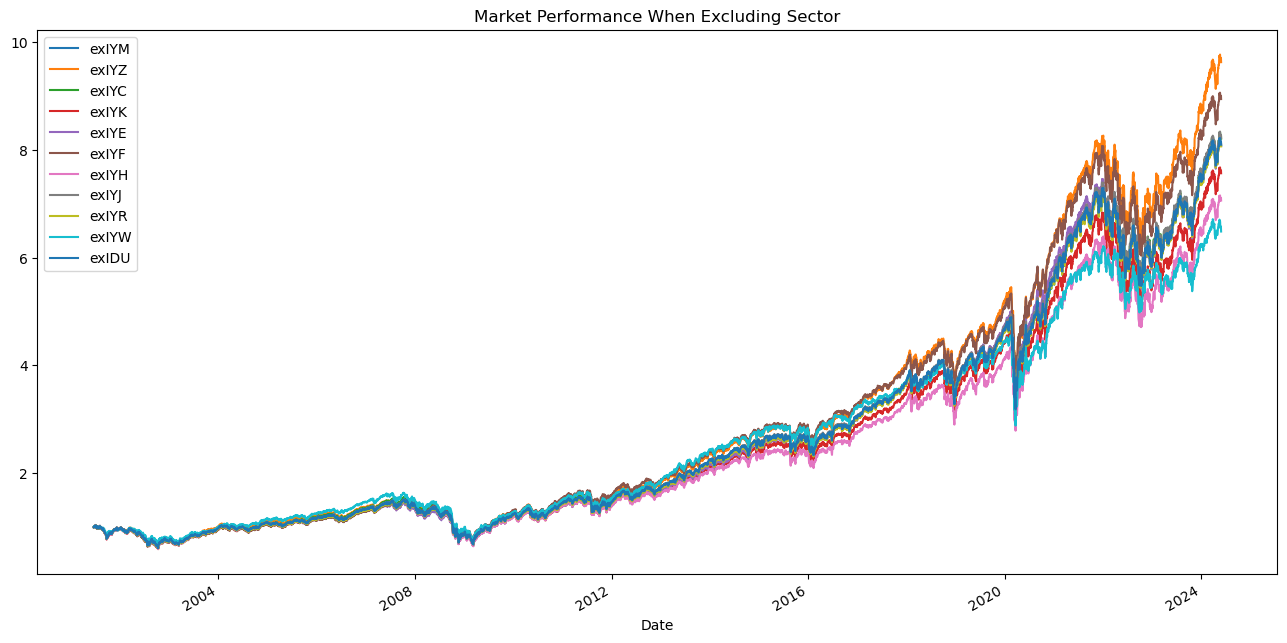

In [11]:
(exSECTOR_RETS+1).cumprod().plot(figsize = (16,8), title="Market Performance When Excluding Sector")

print((exSECTOR_RETS+1).cumprod().iloc[-1,:].sort_values(ascending = False))

Here, we can see that the Telecom (IYZ) sector was the largest detractor from performance, while the Technology (IYW) sector was the largest contributor. Put another way, if we excluded Telecom from the market, we would generate the best returns, while if we excluded Technology, we would have generated the worst returns.

#### DAILY DATA FOR LINEAR REGRESSION

In [12]:
DATA_D = SECTOR_RETS.copy().merge(ETF_RETS_D[["VTI"]], left_index=True, right_index=True)
DATA_D.index = DATA_D.index.date

DATA_D = DATA_D.merge(T5YIE_Data, left_index=True, right_index=True)
DATA_D = DATA_D.merge(DFII5_Data, left_index=True, right_index=True)

DATA_D["T5YIE_DIFF"] = DATA_D["T5YIE"].diff()
DATA_D["DFII5_DIFF"] = DATA_D["DFII5"].diff()
DATA_D[DATA_D.isnull().any(axis=1)]

# Romove nas from bond holidays
DATA_D = DATA_D.ffill().dropna()
DATA_D[DATA_D.isnull().any(axis=1)]

print("Start Date:", DATA_D.index[0])

Start Date: 2003-01-03 00:00:00


Let's see what typical linear regression results look like for the Telecom sector (IYZ):

In [13]:
exETF = "exIYZ"
endog_id = "IYZ"
exog_ids = [exETF, "T5YIE_DIFF", "DFII5_DIFF"]
lr = sm.OLS(endog = DATA_D[endog_id], exog = DATA_D[exog_ids]).fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    IYZ   R-squared (uncentered):                   0.680
Model:                            OLS   Adj. R-squared (uncentered):              0.680
Method:                 Least Squares   F-statistic:                              3818.
Date:                Wed, 29 May 2024   Prob (F-statistic):                        0.00
Time:                        13:23:33   Log-Likelihood:                          18766.
No. Observations:                5385   AIC:                                 -3.753e+04
Df Residuals:                    5382   BIC:                                 -3.751e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
exIYZ          0.8934      0.009    103.430      0.000       0.876       0.910
T5YIE_DIFF    -0.0065      0.002     -2.741      0.006      -0.011      -0.002
DFII5_DIFF    -0.0032      0.002     -1.758      0.079      -0.007       0.000
==============================================================================
Omnibus:                      591.196   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4813.153
Skew:                           0.185   Prob(JB):                         0.00
Kurtosis:                       7.617   Cond. No.                         6.34
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The statistics worth extracting here are the t-values and R2. The t-value measures the size of the difference relative to the variation in our sample data. The greater the magnitude of the t-value, the greater the evidence that the given explanatory variable is related to the dependent variable. Basically, the t-values tell us the direction of the relationship and the magnitude of the given explanatory variable. The R2 tells us how much of the variability is explained by the given linear regression model. 

Let's extract these values and put them in a table:

In [14]:
endog_ids = ["IYZ", "IYC", "IYK", "IYE", "IYF", "IYH", "IYJ", "IYW", "IYR", "IDU", "IYM"]
exETFS = ["exIYZ", "exIYC", "exIYK", "exIYE", "exIYF", "exIYH", "exIYJ", "exIYW", "exIYR", "exIDU", "exIYM"]

combined = zip(endog_ids, exETFS)
endog_dict = dict(combined)

In [15]:
sec_dict = {}
for ETF, exETF in endog_dict.items():

    exog_ids = [exETF, "T5YIE_DIFF", "DFII5_DIFF"]
 
    lr = sm.OLS(endog = DATA_D[ETF], exog = DATA_D[exog_ids]).fit()

    T5YIE = lr.params["T5YIE_DIFF"]
    DFII5 = lr.params["DFII5_DIFF"]
    MKT = lr.params[exETF]
    T5YIE_TV = lr.tvalues["T5YIE_DIFF"]
    DFII5_TV = lr.tvalues["DFII5_DIFF"]
    MKT_TV = lr.tvalues[exETF]
    T5YIE_PV = lr.pvalues["T5YIE_DIFF"]
    DFII5_PV = lr.pvalues["DFII5_DIFF"]
    MKT_PV = lr.pvalues[exETF]
    r2 = lr.rsquared
    
    sec_dict[ETF] = {"MKT_TV": MKT_TV, "T5YIE_DIFF_TV": T5YIE_TV, "DFII5_DIFF_TV": DFII5_TV, "R2": r2}

sec_lr_ex = pd.DataFrame(sec_dict).T
sec_lr_ex.sort_values(by="T5YIE_DIFF_TV")

,MKT_TV,T5YIE_DIFF_TV,DFII5_DIFF_TV,R2
IYR,88.5150,-10.4315,-6.8943,0.6000
IDU,65.4747,-7.1303,-10.0833,0.4495
IYH,91.0147,-2.9134,-1.1666,0.6222
IYZ,103.4304,-2.7414,-1.7579,0.6804
IYC,157.1954,-2.4988,-2.3034,0.8316
IYK,105.3841,-0.7049,-0.9235,0.6902
IYW,99.5519,0.9596,1.5038,0.6683
IYF,104.9520,4.2592,10.0289,0.6977
IYM,108.1029,9.3256,1.8195,0.7110
IYJ,188.0689,9.7850,6.0911,0.8799


Let's put the t-values in a bar chart:

<Axes: title={'center': 'T-Values: 5-Year Breakeven Inflation Change'}>

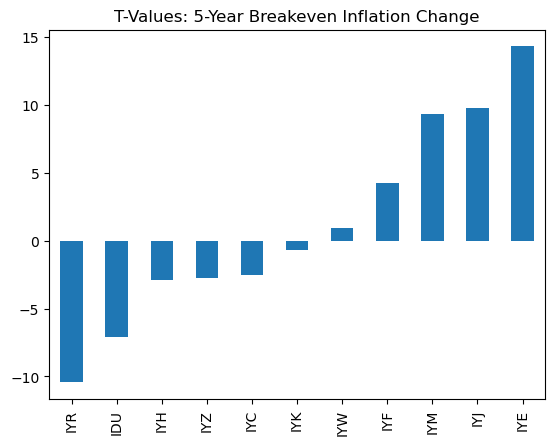

In [16]:
sec_lr_ex.sort_values(by="T5YIE_DIFF_TV")["T5YIE_DIFF_TV"].plot(kind="bar", title = "T-Values: 5-Year Breakeven Inflation Change")

The table shows that the five-year breakeven inflation change has a strong positive relationship with the Energy, Industrials, and Materials sectors. On the other hand, the real estate and utilities sectors have a strong negative relationship with breakeven inflation changes. I found this particularly interesting, given that a popular narrative is that REITS would be a good inflation hedge. 

Let's plot the t-values for 5-Year Real Interest Rates:

<Axes: title={'center': 'T-Values: 5-Year Real Interest Rate Change'}>

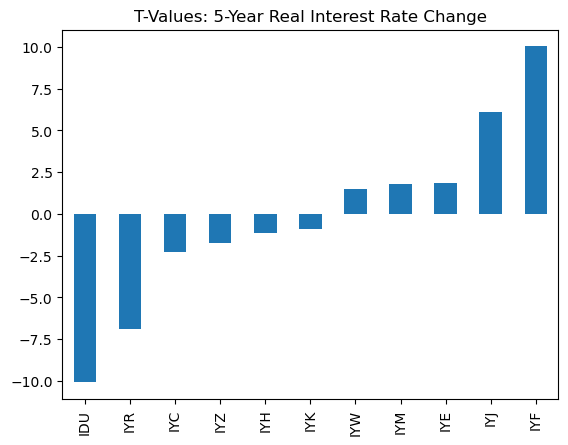

In [17]:
sec_lr_ex.sort_values(by="DFII5_DIFF_TV")["DFII5_DIFF_TV"].plot(kind="bar", title = "T-Values: 5-Year Real Interest Rate Change")

The above t-values chart shows us that five-year real interest rate changes are positively associated with the returns of the Financials and Industrial sectors and negatively associated with the returns of the Utilities and Real Estate sectors.

Overall, my interpretation of these results:
1.	Increasing Inflation & Real Interest Rates: Avoid Utility and REITS and Overweight Industrials.
2.	Increasing Inflation but somewhat stable Real Interest Rates: Avoid Utility and REITS and overweight Energy and Materials.
3.	Increasing Real Interest Rates but somewhat stable Inflation: Overweight Financials.



Let's examine the results if we did not exclude the respective sector from the total market return.

In [18]:
endog_ids = ["IYZ", "IYC", "IYK", "IYE", "IYF", "IYH", "IYJ", "IYW", "IYR", "IDU", "IYM"]
exog_ids = ["VTI", "T5YIE_DIFF", "DFII5_DIFF"]

sec_dict = {}
for ETF in endog_ids:
    
    lr = sm.OLS(endog = DATA_D[ETF], exog = DATA_D[exog_ids]).fit()

    T5YIE = lr.params["T5YIE_DIFF"]
    DFII5 = lr.params["DFII5_DIFF"]
    MKT = lr.params["VTI"]
    T5YIE_TV = lr.tvalues["T5YIE_DIFF"]
    DFII5_TV = lr.tvalues["DFII5_DIFF"]
    MKT_TV = lr.tvalues["VTI"]
    T5YIE_PV = lr.pvalues["T5YIE_DIFF"]
    DFII5_PV = lr.pvalues["DFII5_DIFF"]
    MKT_PV = lr.pvalues["VTI"]
    r2 = lr.rsquared
    
    sec_dict[ETF] = {"MKT_TV": MKT_TV, "T5YIE_DIFF_TV": T5YIE_TV, "DFII5_DIFF_TV": DFII5_TV, "R2": r2}

sec_lr = pd.DataFrame(sec_dict).T
sec_lr.sort_values(by="T5YIE_DIFF_TV")

,MKT_TV,T5YIE_DIFF_TV,DFII5_DIFF_TV,R2
IYR,88.4268,-10.2553,-6.2191,0.5995
IDU,70.2708,-8.0401,-10.4854,0.4842
IYH,105.2137,-4.4460,-1.7654,0.6862
IYC,175.1562,-3.4730,-1.9757,0.8594
IYZ,107.5959,-3.0559,-1.3469,0.6969
IYW,139.1741,-1.8717,-0.0594,0.7950
IYK,113.5726,-1.5437,-0.8934,0.7206
IYF,128.6606,2.2510,8.9589,0.7740
IYM,116.8330,8.6784,1.9060,0.7408
IYJ,206.8568,8.8000,6.6591,0.8984


The results do not change greatly. However, breakeven t-values for Technology (IYW) went from negative to positive, and R2 decreased significantly for the sector. That is not surprising given the large weight of Technology in the total market.

<Axes: title={'center': 'Breakeven Inflation T-Value ex Sector'}>

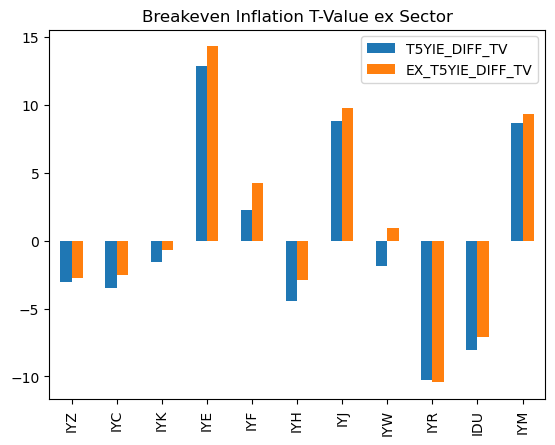

In [19]:
sec_lr_ex.columns = ['EX_' + col for col in sec_lr_ex.columns]
comparison_df = pd.concat([sec_lr, sec_lr_ex], axis = 1)
comparison_df[["T5YIE_DIFF_TV", "EX_T5YIE_DIFF_TV"]].plot(kind = "bar", title = "Breakeven Inflation T-Value ex Sector")

R2s declined across the board. 

<Axes: title={'center': 'R2 ex Sector'}>

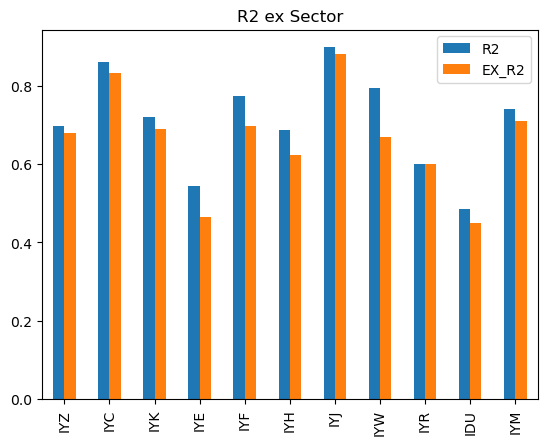

In [20]:
comparison_df[["R2", "EX_R2"]].plot(kind = "bar", title = "R2 ex Sector")